In [2]:
# Deep Learning with Python Ch8: VAE
##############################
#  variational autoencoders  #
##############################
# VAE encoder network
import numpy as np
import keras 
from keras import layers
from keras import backend as K
from keras.models import Model

img_shape  = (28, 28, 1) # gray scale image
latent_dim = 2 # dimension of the latent space: 2D here
batch_size = 16
input_img  = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# input image is encoded into these 2 parameters
z_mean    = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [3]:
# latent space sampling fn
# sample point z from the latent space (or a distribution) defined by z_mean and z_log_var 
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var) * epsilon

# in keras, everything must be a built-in layer
# otherwise, it should be wrapped in a Lambda (aka custom layer)
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [4]:
# VAE decoder network
# input where you feed z
decoder_input = layers.Input(K.int_shape(z)[1:])

# upsample the input
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
# reshape z into a feature map of the same shape as the feature map
# just before the last Flatten layer in the encoder network
x = layers.Reshape(shape_before_flattening[1:])(x)
# decode z into a feature map of the same size as the original image input
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# initiate decoder model that turns decoder_input into the decoded image
decoder   = Model(decoder_input, x)
# apply the decoder model to z to recover decoded z: 
# map point z sampled from the latent space to image
z_decoded = decoder(z)

In [5]:
# set up a custom layer that uses built-in add_loss layer to compute VAE loss
class CustomVariationLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x         = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # reconstruction loss: match decoded sample to initial input
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # regularization loss: learn well-formed latent space and reduce overfitting
        kl_loss   = -5e-4 * K.mean(1+z_log_var-K.square(z_mean)-K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # implement custom layers by writing a call method
    def call(self, inputs):
        x         = inputs[0]
        z_decoded = inputs[1]
        loss      = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x # you don't use this output, but layer must return sth

y = CustomVariationLayer()([input_img, z_decoded])

In [7]:
# train VAE
from keras.datasets import mnist

# turn input_img and y into a model
vae = Model(input_img, y)
vae.summary()
# loss is taken care of in the custom layer, 
# so no need to specify an external loss at compiling
vae.compile(optimizer='rmsprop', loss=None)

# load data
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32')/255
x_train = x_train.reshape(x_train.shape + (1,))
x_test  = x_test.astype('float32')/255
x_test  = x_test.reshape(x_test.shape + (1,))

# train model
# loss it already taken care of, so no need to pass target data
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, 
        validation_data=(x_test, None), verbose=0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

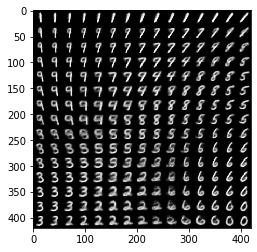

In [10]:
# sample a grid of points from the latent space and decode them into images
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

n          = 15 # display a 15 x 15 grid
digit_size = 28
figure     = np.zeros((digit_size*n, digit_size*n))

# transform linearly spaced coordinate to produce values of the latent variable z
# as the prior of the latent space is Gaussian
gridx      = norm.ppf(np.linspace(0.05, 0.95, n))
gridy      = norm.ppf(np.linspace(0.05, 0.95, n))

for i, xi in enumerate(gridx):
    for j, yi in enumerate(gridy):
        z_sample  = np.array([[xi, yi]])
        # repeat z multiple times to form a complete batch
        z_sample  = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        # decode the batch into digit images
        x_decoded = decoder.predict(z_sample, batch_size=batch_size) 
        # reshape 1st digit in the batch from 28x28x1 to 28x28
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size:(i+1)*digit_size, j*digit_size:(j+1)*digit_size] = digit

plt.imshow(figure, cmap='Greys_r')
plt.show()